In [1]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt


class solver:
    def __init__(self, n_qubits):

        self.n_qubits=n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)

        #observable = [-float(1/self.n_qubits)*cirq.Z.on(q)*cirq.Z.on(q) for q in qubits] 
        #for q in range(len(qubits)):
        #    observable.append(-float(0.5)*cirq.X.on(qubits[q])*cirq.X.on(qubits[(q+1)%len(qubits)]))

        #self.observable = observable
        
        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        

    def append_to_circuit(self, ind, circuit, params, new_index=False):
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params

    def give_circuit(self, lista, one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols
    

    def cirq_friendly_observable(self, obs):
        PAULI_BASIS = {
            'I': np.eye(2),
            'X': np.array([[0., 1.], [1., 0.]]),
            'Y': np.array([[0., -1j], [1j, 0.]]),
            'Z': np.diag([1., -1]),
        }

        pauli3 = cirq.linalg.operator_spaces.kron_bases(PAULI_BASIS, repeat=self.n_qubits)
        decomp = cirq.linalg.operator_spaces.expand_matrix_in_orthogonal_basis(obs, pauli3)

        PAULI_BASIS_CIRQ = {
            'I': cirq.X,
            'X': cirq.X,
            'Y': cirq.Y,
            'Z': cirq.Z,
        }

        unt = []
        for term in decomp.items():
            gate_name = term[0]
            coeff = term[1]
            s = 0
            ot = float(coeff)
            for qpos, single_gate in enumerate(gate_name):
                if single_gate == "I":
                    ot *= PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])*PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
                else:
                    ot *= PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
            if s < 3:
                unt.append(ot)
        return unt


In [5]:
sol=solver(2)
circuit,symbols =sol.give_circuit([sol.number_of_cnots,sol.number_of_cnots+1,0,sol.number_of_cnots,sol.number_of_cnots+1,0,sol.number_of_cnots,sol.number_of_cnots+1,0,sol.number_of_cnots,sol.number_of_cnots+1])
circuit

(0, 0): ───Rz(th_0)───Rx(th_1)───Rz(th_2)───@───Rz(th_6)───Rx(th_7)────Rz(th_8)────@───Rz(th_12)───Rx(th_13)───Rz(th_14)───@───Rz(th_18)───Rx(th_19)───Rz(th_20)───
                                            │                                      │                                       │
(0, 1): ───Rz(th_3)───Rx(th_4)───Rz(th_5)───X───Rz(th_9)───Rx(th_10)───Rz(th_11)───X───Rz(th_15)───Rx(th_16)───Rz(th_17)───X───Rz(th_21)───Rx(th_22)───Rz(th_23)───

In [6]:
tfqcircuit = tfq.convert_to_tensor([circuit])

circuit_input = tf.keras.Input(shape=(), dtype=tf.string)

outps = tfq.layers.PQC(circuit,[cirq.Z(sol.qubits[0]),cirq.Z(sol.qubits[1])])



angles=[[0.,0.], [-np.pi,0.],[0.,-np.pi], [-np.pi,-np.pi]]
qdataset = [cirq.Circuit([cirq.ry(ang1)(sol.qubits[0]), cirq.ry(ang2)(sol.qubits[1])]) for ang1, ang2 in angles]
labs = [[1.,1.], [-1.,1.],[1.,-1.],[-1.,-1.]]

outps(tfq.convert_to_tensor(qdataset))

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.23296219,  0.44150847],
       [-0.14875033, -0.08669233],
       [ 0.5804954 , -0.21613944],
       [-0.1987832 , -0.13867661]], dtype=float32)>

In [7]:
sim = cirq.Simulator()
[sim.simulate(c) for c in qdataset]
#[sim.simulate(cirq.resolve_parameters(circuit,res)) for k in range(4)]

[measurements: (no measurements)
output vector: |00⟩,
 measurements: (no measurements)
output vector: -1|10⟩,
 measurements: (no measurements)
output vector: -1|01⟩,
 measurements: (no measurements)
output vector: |11⟩]

In [8]:
outps(tfq.convert_to_tensor([cirq.Circuit([])]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.23296219,  0.44150847]], dtype=float32)>

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    outps,
])

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=0.01))


In [10]:
model.predict(tfq.convert_to_tensor(qdataset))

array([[-0.23296219,  0.44150847],
       [-0.14875033, -0.08669233],
       [ 0.5804954 , -0.21613944],
       [-0.1987832 , -0.13867661]], dtype=float32)

In [11]:
history = model.fit(tfq.convert_to_tensor(qdataset), tf.convert_to_tensor(labs),batch_size=1, epochs=100)

Train on 4 samples
Epoch 1/100
4/4 [==============================] - 2s 393ms/sample - loss: 0.7040
Epoch 2/100
4/4 [==============================] - 0s 15ms/sample - loss: 0.5839
Epoch 3/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.4851
Epoch 4/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.3889
Epoch 5/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.2924
Epoch 6/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.2232
Epoch 7/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.1675
Epoch 8/100
4/4 [==============================] - 0s 14ms/sample - loss: 0.1250
Epoch 9/100
4/4 [==============================] - 0s 14ms/sample - loss: 0.0932
Epoch 10/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.0669
Epoch 11/100
4/4 [==============================] - 0s 13ms/sample - loss: 0.0507
Epoch 12/100
4/4 [==============================] - 0s 12ms/sample - loss: 0.0380
Epoch

4/4 [==============================] - 0s 13ms/sample - loss: 7.1762e-05
Epoch 98/100
4/4 [==============================] - 0s 12ms/sample - loss: 6.9752e-05
Epoch 99/100
4/4 [==============================] - 0s 12ms/sample - loss: 6.7926e-05
Epoch 100/100
4/4 [==============================] - 0s 13ms/sample - loss: 6.6086e-05


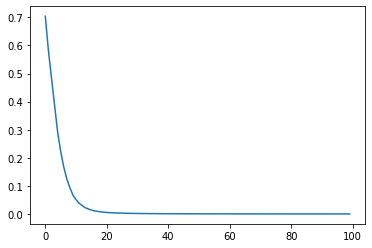

In [12]:
plt.plot(history.history["loss"])

In [13]:
model.trainable_variables

[<tf.Variable 'parameters:0' shape=(24,) dtype=float32, numpy=
 array([6.4348006 , 2.3985968 , 1.9570186 , 4.1542325 , 2.161478  ,
        2.6489956 , 4.770464  , 4.9081707 , 5.252306  , 2.288011  ,
        3.240815  , 0.559709  , 5.2282295 , 1.6871475 , 4.8015795 ,
        4.905895  , 2.7631102 , 2.673824  , 4.735284  , 2.9007018 ,
        2.66785   , 0.08614937, 2.5553336 , 0.72618437], dtype=float32)>]

In [14]:
res={sy:j for sy,j in zip(symbols,model.trainable_variables[0].numpy())}

In [22]:
np.round(cirq.unitary(cirq.resolve_parameters(circuit,res)),4)

array([[-0.4548+0.0352j,  0.0334-0.7364j,  0.1266-0.1977j,
        -0.3811-0.2196j],
       [ 0.0947+0.0378j,  0.2909-0.3284j, -0.1762+0.6839j,
        -0.1632+0.5213j],
       [-0.5925-0.3275j, -0.0376-0.0201j, -0.4259-0.1663j,
         0.4522+0.3555j],
       [ 0.3862-0.4173j, -0.3794-0.3441j, -0.45  +0.186j ,
         0.119 -0.4039j]])

In [23]:
model.predict(tfq.convert_to_tensor(qdataset))

array([[ 0.996352  ,  0.99193054],
       [-0.9975326 ,  0.98893815],
       [ 0.9927864 , -0.99230236],
       [-0.9916049 , -0.98856604]], dtype=float32)

In [24]:
np.dot(np.round(cirq.unitary(cirq.resolve_parameters(circuit,res)),4),np.array([1,0,0,0]))

array([-0.4548+0.0352j,  0.0947+0.0378j, -0.5925-0.3275j,  0.3862-0.4173j])